# Aims
This notebook is created to 
- analyze changes of water yield from 1982 -- 2013
  - magnitude
  - direction
- create figures in main text and supplementary

In [2]:
# load packages
import numpy  as np
import pandas as pd 
import geopandas as gp
import pymannkendall as mk
import matplotlib.pyplot as plt

# define the background
plt.style.use('ggplot')
plt.rc('xtick', direction='in', color='k')
plt.rc('ytick', direction='in', color='k')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='k', axisbelow=True, grid=True)

In [3]:
def sel_time_range(df, start, end):
    # Usage: df = sel_time_range(df, '03-01-1991', '06-01-1997')
    # Note: MM-DD-YYYY
    mask = (df.index >= start) & (df.index <= end)
    df = df.loc[mask]
    return df

def pettitt(idata):
    idata = np.array(idata)
    n = idata.shape[0]
    k = range(n)
    iT = pd.Series(idata)
    r = iT.rank()
    Uk = [2*np.sum(r[0:x])-x*(n + 1) for x in k]
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = Uka.index(U)
    pvalue = 2*np.exp((-6*(U**2))/(n**3+n**2))
    return np.abs(Uk), pvalue, K

In [4]:
# load data
data = pd.read_excel('../01-data/analysis/year_wyd.xlsx')
# convert int64 to datetime64[ns]
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'], format='%Y')
# set the datetime index
data = data.set_index('Unnamed: 0')
data.index.name = 'Year'
# select time range
start = '01-01-1982'
end   = '12-01-2013'
data  = sel_time_range(data, start=start, end=end)

data.head()

,HYZR,UYZR,NCR,MYZR,LSR,LYZR
Year,,,,,,
1982-01-01,94.845546,81.265139,43.103577,99.452416,284.942024,599.076106
1983-01-01,70.555385,68.363718,36.945923,82.087708,215.865170,540.150587
1984-01-01,97.550872,182.251920,54.759136,113.659904,267.672811,595.568634
1985-01-01,114.683134,203.476046,77.850338,138.917660,367.587547,690.971855
1986-01-01,105.673328,103.877034,59.597293,108.924075,212.164624,540.852081


## Trend & abrupt

In [5]:
names = data.columns
pwmmk_res = np.empty((2,6))*np.nan
for i in range(len(names)):
    result = mk.yue_wang_modification_test(data.iloc[:,i], alpha=0.05)
    pwmmk_res[0,i] = result[2]
    pwmmk_res[1,i] = result[7]

pwmmk_res = pd.DataFrame(pwmmk_res, columns=names, index=['pvalue', 'slope'])
print(pwmmk_res)

            HYZR      UYZR       NCR          MYZR       LSR      LYZR
pvalue  0.197391  0.000063  0.096083  1.332268e-15  0.252462  0.256944
slope   0.335256  4.083810  0.559071  7.894963e+00  2.059196  0.537367


In [6]:
# pettitt detection
Uka_r    = np.zeros([data.shape[0], data.shape[1]])
K_r      = np.zeros(data.shape[1])
pvalue_r = np.zeros(data.shape[1]) 

for i in np.arange(0, data.shape[1]):
    Uka_r[:,i], pvalue_r[i], K_r[i]  = pettitt(data.iloc[:,i])

In [7]:
windows_num = 3
data_3y     = data.rolling(window=windows_num, center=True).mean()
# calculation
Uka_r    = np.zeros([data.shape[0], data.shape[1]])
K_r      = np.zeros(data.shape[1])
pvalue_r = np.zeros(data.shape[1]) 

for i in np.arange(0, data.shape[1]):
    Uka_r[:,i], pvalue_r[i], K_r[i]  = pettitt(data_3y.iloc[:,i])

print('-----------position of turning points----------------')
print(K_r)
print('-----------year of turning point----------------')
print(K_r+1982)
print('-----------p value----------------')
print(pvalue_r<0.05)

-----------position of turning points----------------
[13. 16. 15. 15. 14. 15.]
-----------year of turning point----------------
[1995. 1998. 1997. 1997. 1996. 1997.]
-----------p value----------------
[False  True  True  True  True  True]


In [8]:
# cumulative anomaly
data_anm = data - data.mean(axis=0)
data_sum = data_anm.cumsum()

In [9]:
gdf = gp.read_file('../01-data/geo_files/watershed/YZR.shp')
# set Name as an index
gdf = gdf.set_index('Name')
# add one column of Rmean
gdf['R_mean'] = data.mean()
# add one column of Rtrend
gdf['R_trend'] = pwmmk_res.iloc[1,:]
# add one column of pvalue_R
gdf['pvalue_R'] = pwmmk_res.iloc[0,:]
# view
gdf

,geometry,R_mean,R_trend,pvalue_R
Name,,,,
HYZR,"MULTIPOLYGON (((83.60830 30.53948, 83.60822 30...",104.933355,0.335256,1.973912e-01
LSR,"MULTIPOLYGON (((92.18698 29.87501, 92.18889 29...",360.864246,2.059196,2.524615e-01
LYZR,"MULTIPOLYGON (((94.09981 30.26723, 94.09963 30...",630.872082,0.537367,2.569437e-01
MYZR,"MULTIPOLYGON (((91.99549 29.47220, 91.99545 29...",232.147801,7.894963,1.332268e-15
NCR,"POLYGON ((89.81436 29.03409, 89.81434 29.03326...",78.254663,0.559071,9.608278e-02
UYZR,"MULTIPOLYGON (((89.17566 29.26306, 89.17661 29...",215.662303,4.083810,6.262188e-05


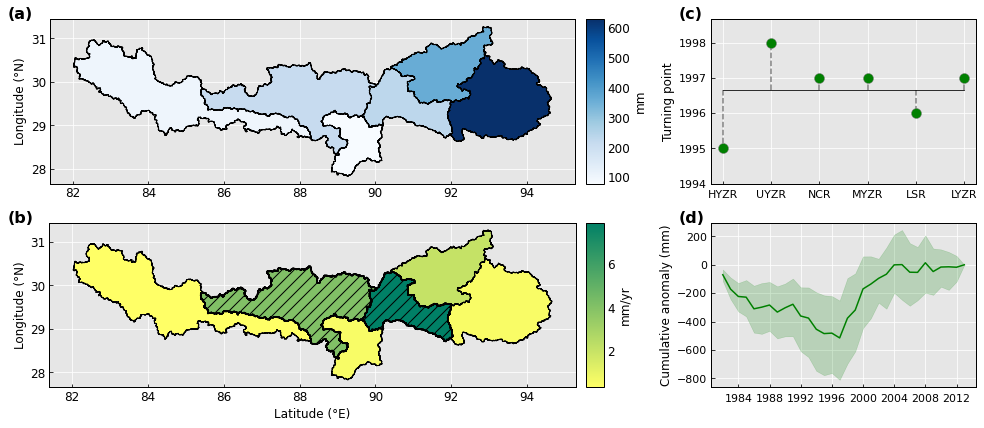

In [10]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(nrows=2, ncols=3)
### (a) and (b)
colors = ['Blues','summer_r']
for i in range(2):
    ax = fig.add_subplot(spec[i,0:2])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=-.4)

    gdf.plot(ax=ax, column=gdf.columns[i+1], cmap=colors[i], 
            edgecolor='k', linewidth=1.0, cax=cax, legend=True,
            legend_kwds={'orientation': "vertical"})
    cax.tick_params(axis='both', which='major', labelsize=12)
    
    if i == 0:
        cax.set_ylabel('mm', fontsize=12, color='k')
    else:
        cax.set_ylabel('mm/yr', fontsize=12, color='k')

    ax.set_ylabel('Longitude (°N)', fontsize=12, color='k')
    ax.tick_params(axis='both', which='major',  labelsize=12, direction='in')
    if i == 0:
        ax.text(-0.08, 1.0, '(a)', color='k', weight="bold", fontsize=16, transform=ax.transAxes)
    else:
        ax.text(-0.08, 1.0, '(b)', color='k', weight="bold", fontsize=16, transform=ax.transAxes)
    if i == 1:
        gdf[gdf["pvalue_R"] < 0.05].geometry.boundary.plot(color=None, edgecolor='k',hatch="//", ax=ax)
        ax.set_xlabel('Latitude (°E)', fontsize=12, color='k')

### (c)
ax = fig.add_subplot(spec[0,2])
# data
x = names; y = K_r+1982
(markers, stemlines, baseline) = ax.stem(x, y, bottom=(np.mean(y)))
# plot
plt.setp(baseline, linestyle="-", color="k" , linewidth=0.8)
plt.setp(markers , marker='o', color='green', markersize=10, markeredgecolor="grey", markeredgewidth=0.5)
plt.setp(stemlines, linestyle='--', color='grey', linewidth=1.5)

ax.set_ylim(np.min(y)-1, np.mean(y)+2, 1)
ax.text(-0.12, 1.0, '(c)', color='k',  weight="bold", fontsize=16, transform=ax.transAxes)
ax.tick_params(axis='y', which='major', labelsize=11)
ax.tick_params(axis='x', which='major', labelsize=11, rotation=0, pad=6)
ax.set_ylabel('Turning point', fontsize=12, color='k')
### (d)
# data 
data_sum['Year'] = data_sum.index # cumulative anomaly
# convert the fromat for seaborn https://seaborn.pydata.org/tutorial/data_structure.html
data_long = data_sum.melt(id_vars=['Year'], var_name="name", value_name='data') 
# plot
ax = fig.add_subplot(spec[1,2])
sns.lineplot(ax=ax, data=data_long, x='Year', y='data', ls='-',color='g')

ax.text(-0.12, 1.0, '(d)', color='k',  weight="bold", fontsize=16, transform=ax.transAxes)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='x', which='major', labelsize=11, rotation=0, pad=6)
ax.set_xlabel('')
ax.set_ylabel('Cumulative anomaly (mm)', fontsize=12, color='k')

plt.tight_layout(w_pad=0)

# save 
plt.savefig('../03-res/02-figures/spatial-changes-in-water-yield.png', dpi=300, bbox_inches='tight')

## Magnitude & direction

In [11]:
print("turning point", K_r)
print("turning year", K_r+1982)

turning point [13. 16. 15. 15. 14. 15.]
turning year [1995. 1998. 1997. 1997. 1996. 1997.]


### Magnitude shifts

In [12]:
# turning point 
tp = K_r
# calculation
magnitude = np.zeros([6,6])
'''
# row 1: mean water yield before tp; 
# ror 2: mean water yield after tp; 
# row 3: mean water yield differences;
# row 4: std before tp;
# row 5: std after tp;
'''
for i in range(0,6):
    magnitude[0,i] = data.iloc[0:int(tp[i]),i].mean()
    magnitude[1,i] = data.iloc[int(tp[i]):,i].mean()
    magnitude[2,i] = magnitude[1,i] - magnitude[0,i]
    magnitude[3,i] = data.iloc[0:int(tp[i]),i].std()
    magnitude[4,i] = data.iloc[int(tp[i]):,i].std()
    magnitude[5,i] = (magnitude[2,i]/magnitude[0,i])*100

magnitude = pd.DataFrame(magnitude, index=['mean_bf','mean_af','dif','std_bf','std_af', 'rate'], columns=names)
print('water yield magnitudes:', '\n', magnitude)

rate = magnitude.iloc[5,:]

water yield magnitudes: 
                HYZR        UYZR        NCR        MYZR         LSR        LYZR
mean_bf   99.314139  164.859900  68.511230  162.596807  319.392343  607.353738
mean_af  108.778083  266.464706  86.851810  293.516325  393.120170  651.623562
dif        9.463944  101.604806  18.340581  130.919517   73.727827   44.269824
std_bf    19.255675   67.312068  18.524105   60.117591   86.597102   74.508184
std_af    21.180572   66.388569  27.558983  111.383999  118.704527  134.245505
rate       9.529301   61.631001  26.770182   80.517889   23.083780    7.288969


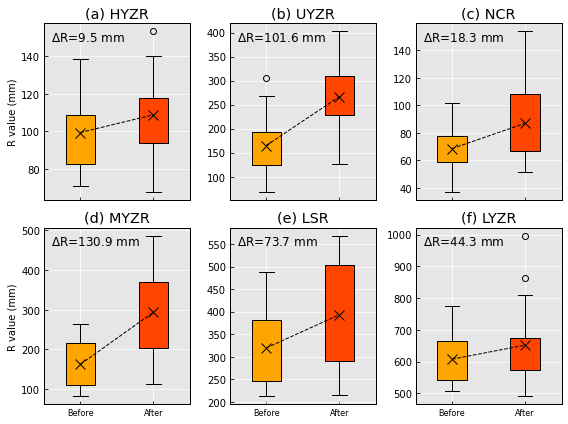

In [13]:
fig = plt.figure(figsize=(8,6))
left = 1; right = 2;
order = ['(a)','(b)','(c)','(d)','(e)','(f)']
colors = ['orange', 'orangered']
for i in range(len(names)):
    ax = plt.subplot(2,3,i+1)

    tpi = int(tp[i])
    x1 = data.iloc[0:tpi,i]; x2 = data.iloc[tpi:,i]
    x  = [x1, x2]
   
    bp = ax.boxplot(x, widths=0.4, patch_artist=True, showmeans=False)
    for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color) 
    for median in bp['medians']: median.set(color ='red', linewidth = 0) 
    
    # plot line
    ax.plot([left, right], [magnitude.iloc[0,i], magnitude.iloc[1,i]], 'kx--', markersize=10, linewidth=1)     
    # add information
    ax.set_title(order[i] + ' ' + names[i], color='k')   
    ######################################### 
    if i == 0 or i == 3:
        ax.set_ylabel('R value (mm)', fontsize=10, color='k')
    if i == 3 or i == 4 or i == 5:
        ax.set_xticks([left,right], ['Before','After'], fontsize=8, color='k')
    else:
        ax.set_xticks([left,right], ['',''])
    # plt.text
    ax.text(0.05, 0.9, r'$\Delta$R='+'%.1f'%magnitude.iloc[2,i]+'$\ $'+'mm', color='k',  fontsize=12, transform=ax.transAxes)
plt.tight_layout()

### Direction shifts

In [14]:
# slope calculation
slope = np.zeros([5,6])
'''
# row 1: slop before tp; 
# ror 2: slop after tp; 
# row 3: slop difference;
'''

for i in np.arange(0,6):
    slope[0,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[7]
    slope[1,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[7]
    slope[2,i] = slope[1,i] - slope[0,i]
    slope[3,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[2]
    slope[4,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[2]

slope = pd.DataFrame(slope, index=['slope_bf','slope_af','dif', 'pvalue_bf','pvalue_af'], columns=names)
print('water yield directions', '\n', slope)

water yield directions 
                HYZR      UYZR       NCR      MYZR        LSR      LYZR
slope_bf   1.042387  0.966037  1.519421  8.945455   4.405412  0.000000
slope_af  -1.287203 -7.623185 -3.077161  3.636079 -11.512809 -4.684144
dif       -2.329590 -8.589222 -4.596582 -5.309376 -15.918221 -4.684144
pvalue_bf  0.731702  0.692181  0.381074  0.062698   0.427711  1.000000
pvalue_af  0.255818  0.022822  0.007900  0.752642   0.043546  0.300427


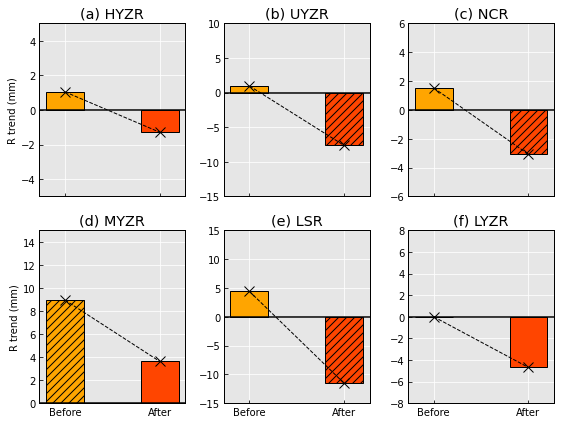

In [15]:
fig = plt.figure(figsize=(8,6))
left = 0; right = 1; width = 0.4
# ylim
y_up = [ 5,   10,  6, 15, 15,  8]
y_lw = [-5, -15, -6,  0, -15, -8]
abs_y = np.array(y_up) - np.array(y_lw)

for i in range(len(names)):
    ax = plt.subplot(2,3,i+1)
    if slope.iloc[3,i]<0.10:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=['orange'], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=['orange'], edgecolor='k', lw=1)
    if slope.iloc[4,i]<0.10:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=['orangered'], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=['orangered'], edgecolor='k', lw=1)
    # plot line
    plt.plot([left, right], [slope.iloc[0,i], slope.iloc[1,i]], 'kx--', markersize=10, linewidth=1)     
    # add information
    ax.set_title(order[i] + ' ' + names[i], color='k')
    #########################################
    plt.axhline(y=0, ls='-', c='k')
    #########################################
    plt.ylim([y_lw[i], y_up[i]])
    # save the label infomation in the left and bottom 
    if i == 0 or i == 3:
        plt.ylabel('R trend (mm)', fontsize=10, color='k')
    if i == 3 or i == 4 or i == 5:
        plt.xticks([left,right], ['Before','After'], fontsize=8)
    else:
        plt.xticks([left,right], ['',''])
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)        

plt.tight_layout()

### Combination

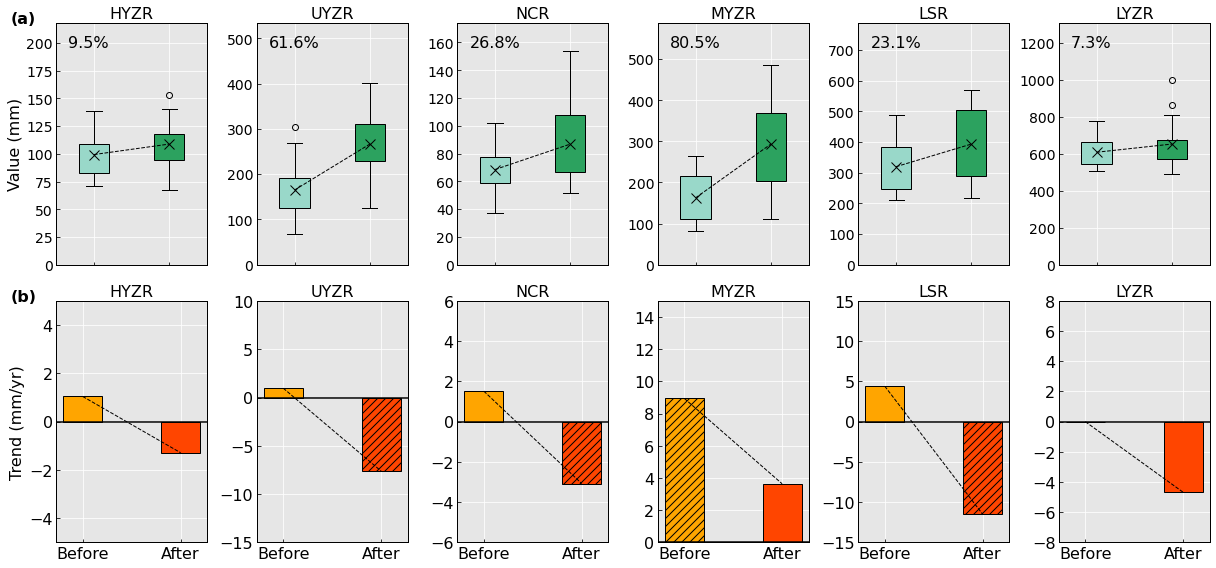

In [18]:
fig = plt.figure(figsize=(17,8))
left = 1; right = 2; width = 0.4

#################################### (a)
for i in range(len(names)):
    ax = plt.subplot(2,6,i+1)
    tpi = int(tp[i])
    colors = ['#99d8c9', '#2ca25f']
    x1 = data.iloc[0:tpi,i]; x2 = data.iloc[tpi:,i]
    x  = [x1, x2]
    bp = ax.boxplot(x, widths=0.4, patch_artist=True, showmeans=False)
    for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color) 
    for median in bp['medians']: median.set(color ='red', linewidth = 0) 
    # plot line
    ax.plot([left, right], [magnitude.iloc[0,i], magnitude.iloc[1,i]], 'kx--', markersize=10, linewidth=1)   
    # add information
    plt.title(label=names[i], pad=5, fontsize=16)     
    ######################################### 
    if i == 0:
        plt.ylabel('Value (mm)', fontsize=16, color='k')
        ax.text(-0.3, 1.0, '(a)', color='k',  weight="bold", fontsize=16, transform=ax.transAxes)
    
    plt.xticks([left,right], ['',''])
    plt.yticks(fontsize=14); plt.xticks(fontsize=14)
    # set bottom
    plt.ylim([0, 2*magnitude.iloc[1,i]])
    # plt.text
    ''' show "mm" and "%"
    ax.text(0.03, 0.9, 
            r'$\Delta$R='+'%.1f'%magnitude.iloc[2,i]+'mm'
            +'$\ $'+'('+ '%.1f'%rate[i] +'%)', 
            color='k',  fontsize=12, transform=ax.transAxes)
    '''
    ax.text(0.08, 0.9, 
            '%.1f'%rate[i] +'%', 
            color='k',  fontsize=16, transform=ax.transAxes)

#################################### (b)
# ylim
y_up = [ 5,  10,  6, 15,  15,  8]
y_lw = [-5, -15, -6,  0, -15, -8]
abs_y = np.array(y_up) - np.array(y_lw)
for i in range(len(names)):
    ax = plt.subplot(2,6,i+7)
    # plot
    if slope.iloc[3,i]<0.10:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=['orange'], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=['orange'], edgecolor='k', lw=1)
    if slope.iloc[4,i]<0.10:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=['orangered'], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=['orangered'], edgecolor='k', lw=1)
    # plot line
    plt.plot([left, right], [slope.iloc[0,i], slope.iloc[1,i]], 'k--', markersize=10, linewidth=1)     
    # add information
    plt.title(label=names[i], pad=5, fontsize=16)
    #########################################
    plt.axhline(y=0, ls='-', c='k')
    #########################################
    plt.ylim([y_lw[i], y_up[i]])
    # save the label infomation in the left and bottom 
    if i == 0:
        plt.ylabel('Trend (mm/yr)', fontsize=16, color='k')
    plt.xticks([left,right], ['Before','After'])
    plt.yticks(fontsize=16); plt.xticks(fontsize=16)
    
    # add title
    if i == 0:
        ax.text(-0.3, 1.0, '(b)', color='k',  weight="bold", fontsize=16, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../03-res/02-figures/magnitude_and_direction.png', dpi=300, bbox_inches='tight')